<a href="https://colab.research.google.com/github/rokmr/Image-Processing/blob/main/Image__Processing_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Input image

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import urllib.request
from tabulate import tabulate 
from tqdm.auto import tqdm

In [4]:
%%capture
!pip install BM3D
from bm3d import bm3d, BM3DProfile, BM3DStages

In [5]:
!git clone https://github.com/rokmr/Image-Processing.git
!cp -r /content/Image-Processing/Images/05 /content/images

Cloning into 'Image-Processing'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 66 (delta 1), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (66/66), 6.35 MiB | 11.23 MiB/s, done.


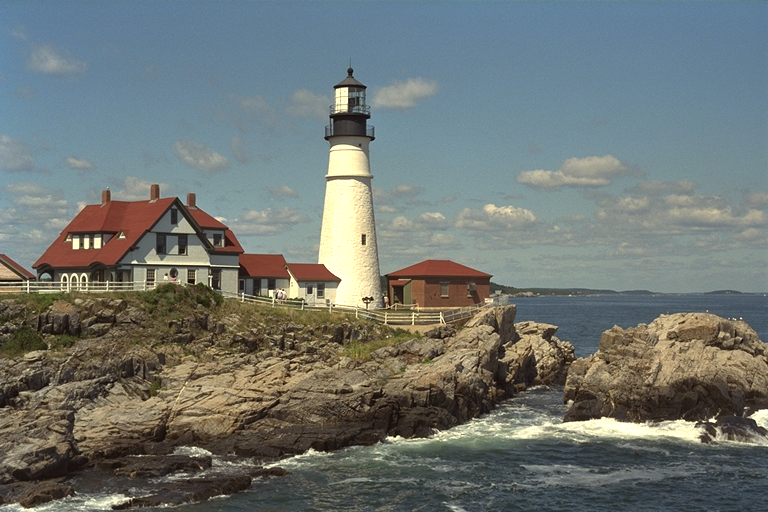

In [9]:
# Reading image
image = cv2.imread('/content/images/lighthouse2.bmp',cv2.IMREAD_UNCHANGED)
cv2_imshow(image)

#Linear combinations of order statistics for uniformly distributed noise 

Consider the noise model Yi = x+Zi for i ∈ {1, 2, · · · , N} for N = 5 where Zi are independent and
identically distributed according to a uniform distribution Unif[−1, 1]. Compute the order statistics
filter coefficients (α1, α2, · · · , αN ) that minimize the mean squared error between ̂X and x 

where Xˆ = ∑ α_i y_(i).
[Ref Paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1164247)



In [ ]:
N = 5

H = np.zeros((N,N))

# Calculating off diagonal element
for k in range(5):
  for l in range(k+1,5):
    i = k+1
    j = l+1
    
    a = i-1
    b = j-i-1
    c = N - j

    k_ij = np.math.factorial(N) / ( np.math.factorial(a) * np.math.factorial(b) *np.math.factorial(c))

    f = lambda x,y : x * y * k_ij * (1+x) **a * (y-x)**b * (1-y)**c * 2**(-N)

    H[k,l],_ = integrate.dblquad(f, -1, 1, lambda x:-1, lambda x: x)

H = H + H.T

# Calculating off diagonal element
for k in range(N):
  i = k+1
  k_ii = np.math.factorial(N)/(np.math.factorial(N-i) * np.math.factorial(i-1))

  f = lambda x: k_ii * x**2* (1+x)**(i-1) * (1-x)**(N-i) * 2**(-N)
  H[k,k],_ = integrate.quad(f, -1, 1 )

print(H)

[[ 0.52380952  0.28571429  0.04761905 -0.19047619 -0.42857143]
 [ 0.28571429  0.23809524  0.0952381  -0.04761905 -0.19047619]
 [ 0.04761905  0.0952381   0.14285714  0.0952381   0.04761905]
 [-0.19047619 -0.04761905  0.0952381   0.23809524  0.28571429]
 [-0.42857143 -0.19047619  0.04761905  0.28571429  0.52380952]]


In [ ]:
e = np.ones((N))
alpha = (np.linalg.inv(H)@e)/(e@np.linalg.inv(H)@e.T)
print(alpha)

[ 5.00000000e-01  9.93357443e-16 -9.40385336e-16 -5.07530526e-16
  5.00000000e-01]


******
**alpha = [0.5 0 0 0 0.5] for the uniform density noise between -1 and 1.**
******

# Block Matching and 3D Filtering

Take the lighthouse image provided to you, convert to greyscale and add white Gaussian noise with
variance σ
2
Z = 100 to it. Be sure to add noise in the grey scale domain where the range of pixel
values is between 0 and 255



1.   Compare the MSE performance at the output of the first and second stages of the BM3D
method. The BM3D algorithm has two stages in its implementation.

2.    Study the performance variation of the entire algorithm with respect to the choice of the
input noise variance σ
2
Z
in the algorithm. You can plot a curve between MSE and σ
2
Z
to
understand this relationship. Explain why you get such a curve.
3.    Replace the Wiener filter in the second stage with a hard thresholding estimate and compare
the performance with the former in terms of MSE

[Ref Paper](https://webpages.tuni.fi/foi/GCF-BM3D/BM3D_TIP_2007.pdf)

[Implementation Link](https://webpages.tuni.fi/foi/GCF-BM3D/)


In [ ]:
class PROBLEM_2():
    def __init__(self, image, noise_mean, noise_var):
    # Convering image to grayscale afd downscaleing for easy computation
      self.grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      self.noise_mean = noise_mean
      self.noise_var = noise_var
      self.gauss_noise = np.random.normal(self.noise_mean, np.sqrt(self.noise_var), self.grayscale.shape)
      self.gauss_noise_image = self.grayscale + self.gauss_noise

      self.noise_var2 = noise_var * 1.6
      self.gauss_noise2 = np.random.normal(self.noise_mean, np.sqrt(self.noise_var2), self.grayscale.shape)
      self.gauss_noise_image2 = self.grayscale + self.gauss_noise2

      self.stage1_output = None
      self.stage2_output = None
      self.MSE_LIST = None

      
      self.σ = np.arange(1,21,1)
      self.σ_2 =  (self.σ)**2

        
    def __str__(self):
      return f"BM3D on noisy Image"
    
    def plotter(self, image, name):  
      plt.imshow(image, cmap= 'gray')
      plt.title(name,fontsize=24)
      plt.axis(False)
      return 0

    def BM3D_stage1_output(self, image, sigma):
      img = bm3d(image, sigma, stage_arg=BM3DStages.HARD_THRESHOLDING)
      return img

    def BM3D_stage2_output(self, image, sigma):
      img = bm3d(image, sigma, stage_arg=BM3DStages.ALL_STAGES)
      return img

    def mse(self, image):
      mse = np.mean((self.grayscale - image) ** 2)
      return mse
      
    def part_1(self):
      print("SOLVING Q2 PART-1")
      self.stage1_output = self.BM3D_stage1_output(self.gauss_noise_image, np.sqrt(self.noise_var))
      self.stage2_output = self.BM3D_stage2_output(self.gauss_noise_image, np.sqrt(self.noise_var))
      
      mse_input = self.mse(self.gauss_noise_image)
      mse_stage1 = self.mse(self.stage1_output)
      mse_stage2 = self.mse(self.stage2_output)

      fig = plt.figure(figsize=(20,20))
      fig.suptitle("Q2 PART-1 IMAGES")
      fig.add_subplot(2, 2, 1)
      self.plotter(self.grayscale,"GRAYSCALE")
      fig.add_subplot(2, 2, 2)
      self.plotter(self.gauss_noise_image,"NOISY IMAGE")
      fig.add_subplot(2, 2, 3)
      self.plotter(self.stage1_output,"BM3D_STAGE1_OUTPUT")
      fig.add_subplot(2, 2, 4)
      self.plotter(self.stage2_output,"BM3D_STAGE2_OUTPUT")
      plt.tight_layout()
      plt.show()

      MSE = [["INPUT TO BM3D", mse_input],["STAGE-1", mse_stage1],["STAGE-2", mse_stage2]]
      HEADERS = ["MSE", "VALUE"]
      print(tabulate(MSE, HEADERS, tablefmt="fancy_grid"))

    def part_2(self):
        
        print("SOLVING Q2 PART-2")
        
        self.MSE_LIST = [] 
        self.MSE_LIST2 = []
        for sigma in tqdm(self.σ):
          bm3d_op = self.BM3D_stage2_output(self.gauss_noise_image, sigma)
          bm3d_op2 = self.BM3D_stage2_output(self.gauss_noise_image2, sigma)
          self.MSE_LIST.append(self.mse(bm3d_op))
          self.MSE_LIST2.append(self.mse(bm3d_op2))
          


        self.min_mse = min(self.MSE_LIST)
        self.min_mse_index = self.MSE_LIST.index(self.min_mse)
        self.min_σ_2= self.σ_2[self.min_mse_index]

        self.min_mse2 = min(self.MSE_LIST2)
        self.min_mse_index2 = self.MSE_LIST2.index(self.min_mse2)
        self.min_σ_2_2= self.σ_2[self.min_mse_index2]

        plt.title(f"PLOT BETWEEN MSE AND σ^2")
        plt.plot(self.σ_2, self.MSE_LIST,marker='o',ms=2, label="noise var = 100")
        plt.plot(self.min_σ_2, self.min_mse, marker='o', color='r')

        # plt.annotate(f"Min_MSE: {min_mse:.3f} \n VAR: {min_σ_2:.3f}", xy=(min_σ_2-30, min_mse+5) , color='g')
        plt.plot(self.σ_2, self.MSE_LIST2,marker='o',ms=2,  label="noise var = 160")
        plt.plot(self.min_σ_2_2, self.min_mse2, marker='o', color='r')
        # plt.annotate(f"Min_MSE: {min_mse2:.3f} \n VAR: {min_σ_2_2:.3f}", xy=(min_σ_2-30, min_mse+5) , color='m')

        plt.xlabel("VAR",fontsize=20)
        plt.ylabel("MSE",fontsize=20)
        plt.legend()
        plt.show()

    def part_3(self):
        print("SOLVING Q2 PART-3")
        self.wei_replacedby_ht = self.BM3D_stage1_output(self.stage1_output, np.sqrt(self.noise_var))
        mse_stage2 = self.mse(self.stage2_output)
        mse_wei_replacedby_ht = self.mse(self.wei_replacedby_ht)

        MSE = [["WIENER WITHOUT REPLACED",mse_stage2],["WIENER REPLACED", mse_wei_replacedby_ht]]
        HEADERS = ["MSE", "VALUE"]
        print(tabulate(MSE, HEADERS, tablefmt="fancy_grid"))
        

        self.MSE_LIST3 = []
        for sigma in tqdm(self.σ):
          ht_output = self.BM3D_stage1_output(self.gauss_noise_image, sigma)
          bm3d_op3 = self.BM3D_stage1_output(ht_output, sigma)
          error = self.mse(bm3d_op3)
          self.MSE_LIST3.append(error)

        self.min_mse3 = min(self.MSE_LIST3)
        self.min_mse_index3 = self.MSE_LIST3.index(self.min_mse3)
        self.min_σ_2_3 = self.σ_2[self.min_mse_index3]
        
        plt.title(f"PLOT BETWEEN MSE AND σ^2")
        plt.plot(self.σ_2, self.MSE_LIST,marker='o',ms=2, label="WITH WIENER")
        plt.plot(self.min_σ_2, self.min_mse, marker='o', color='r')
        plt.plot(self.σ_2, self.MSE_LIST3, marker='o',ms=2,  label="WITHOUT WIENER")
        plt.plot(self.min_σ_2_3, self.min_mse3, marker='o', color='r')
        plt.xlabel("VAR",fontsize=20)
        plt.ylabel("MSE",fontsize=20)
        plt.legend()
        plt.show()


    def __call__(self):
      self.part_1()
      self.part_2()
      self.part_3()

In [ ]:
A = PROBLEM_2(image=image,
              noise_mean=0,
              noise_var=100)


SOLVING Q2 PART-1


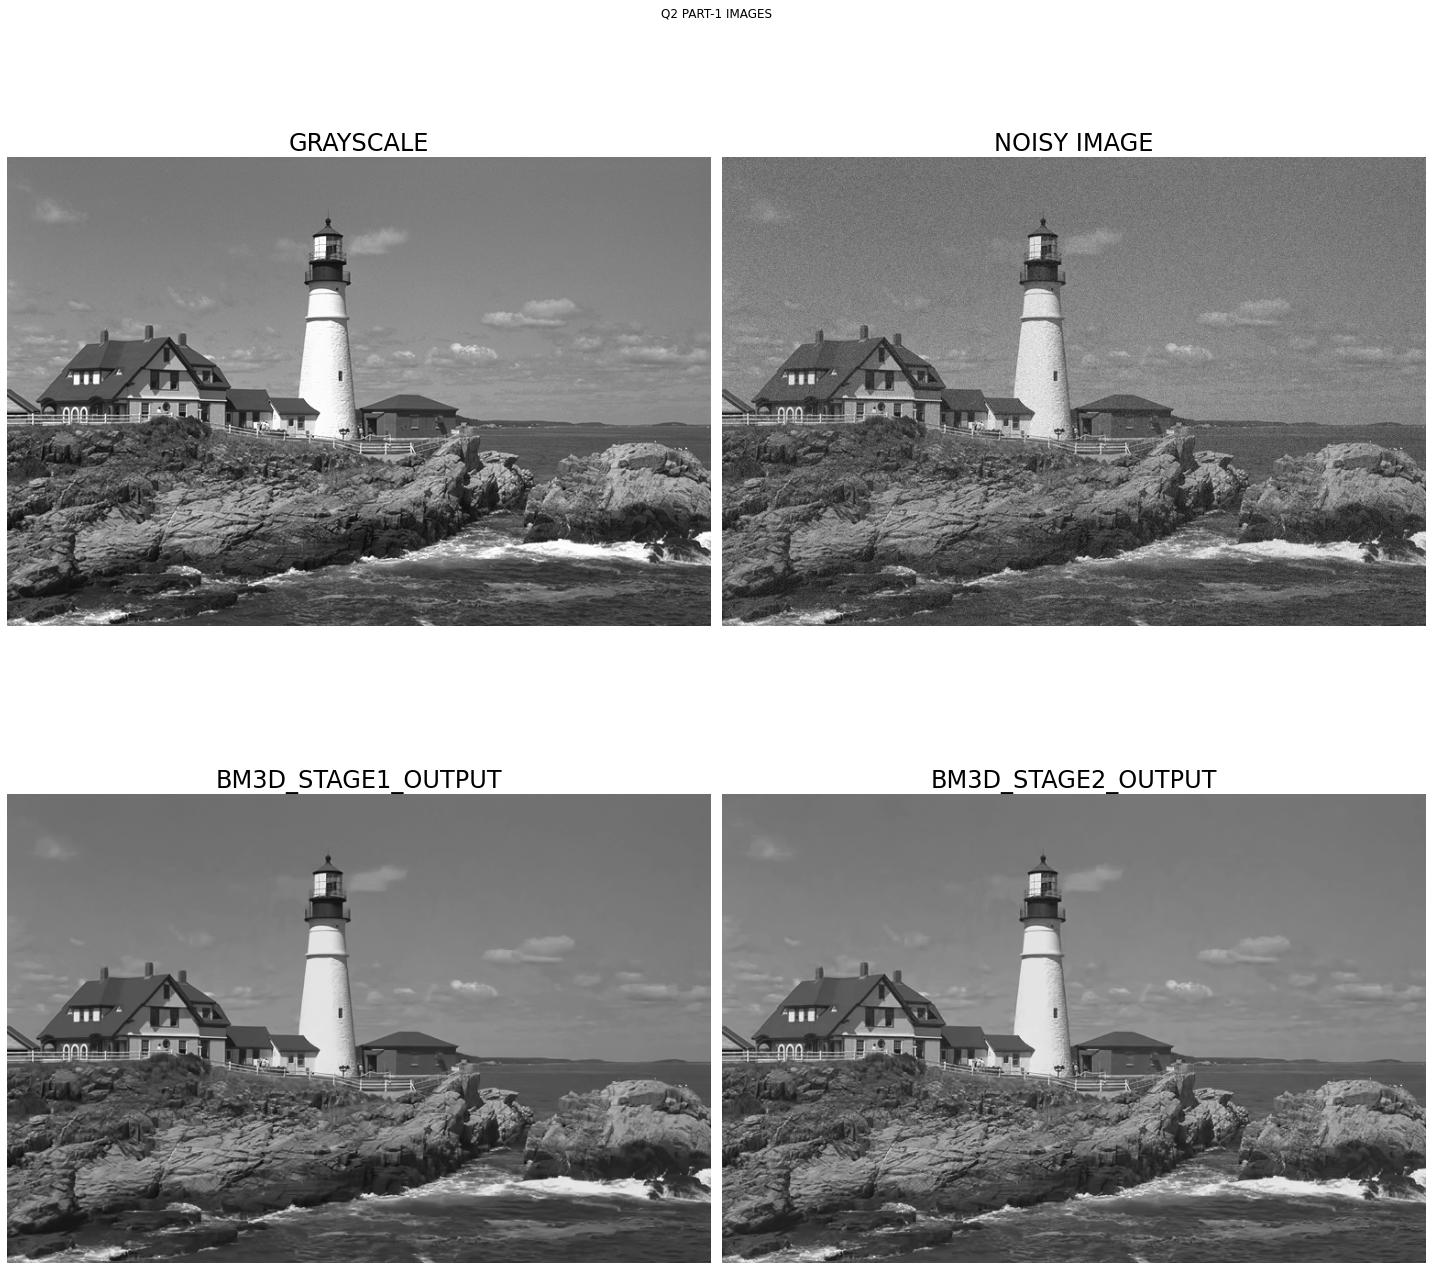

╒═══════════════╤══════════╕
│ MSE           │    VALUE │
╞═══════════════╪══════════╡
│ INPUT TO BM3D │ 100.112  │
├───────────────┼──────────┤
│ STAGE-1       │  32.7258 │
├───────────────┼──────────┤
│ STAGE-2       │  27.8695 │
╘═══════════════╧══════════╛


In [ ]:
A.part_1() 

******
**The input noisyimage had MSE of 100.112 when fed to the BM3D. After, passing through BM3D, the 
MSE with respect to first stage output and second stage output is 32.7258 and 27.7258 respectively. 
From this we can conclude that after the Basic Estimate Stage (i.e., hard thresholdig ) most of the 
noise noise is being removed. Some of the noise were even removed in the Final Estimate (i.e., 
Wiener thresholding stage). Overall the output of second stagewas better than first stage of BM3D**
******

SOLVING Q2 PART-2


  0%|          | 0/20 [00:00<?, ?it/s]

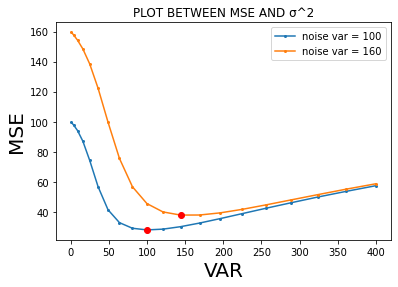

In [ ]:
A.part_2()

In [ ]:
MSE = [["100", A.min_mse, A.min_σ_2],["160", A.min_mse2, A.min_σ_2_2]]
HEADERS = ["NOISE WITH VAR", "MIN MSE", "RESPECTIVE VAR"]
print(tabulate(MSE, HEADERS, tablefmt="fancy_grid"))

╒══════════════════╤═══════════╤══════════════════╕
│   NOISE WITH VAR │   MIN MSE │   RESPECTIVE VAR │
╞══════════════════╪═══════════╪══════════════════╡
│              100 │   27.8695 │              100 │
├──────────────────┼───────────┼──────────────────┤
│              160 │   37.7546 │              144 │
╘══════════════════╧═══════════╧══════════════════╛


******
**For given choice of the var = 100 we plotted the curve between MSE and variance( BM3D) 
parameter and it was found that the MSE loss was minimum at the variance = 100. I tried adding 
noise at the same grayscale image at var = 160 and it was found that the MSE was minmum at 
variance(BM3D) = 160. From the above observations it can be concluded that the MSE is minimum 
at the variance(BM3D) = var(Noise) being added to the image.**

**Here Var = 144 because we have been plotting for sigma increment of 2. So, minima turn out to be 
between sigma 12 and 13.**
******

SOLVING Q2 PART-3
╒═════════════════════════╤═════════╕
│ MSE                     │   VALUE │
╞═════════════════════════╪═════════╡
│ WIENER WITHOUT REPLACED │ 27.8695 │
├─────────────────────────┼─────────┤
│ WIENER REPLACED         │ 63.0152 │
╘═════════════════════════╧═════════╛


  0%|          | 0/20 [00:00<?, ?it/s]

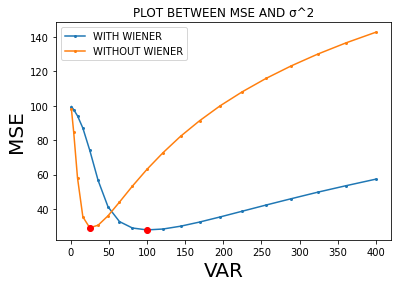

In [ ]:
A.part_3() 

In [ ]:
MSE = [["WITH WIENER", A.min_mse, A.min_σ_2],["WITHOUT WIENER", A.min_mse3, A.min_σ_2_3]]
HEADERS = ["MODEL", "MIN MSE", "RESPECTIVE VAR"]
print(tabulate(MSE, HEADERS, tablefmt="fancy_grid"))

╒════════════════╤═══════════╤══════════════════╕
│ MODEL          │   MIN MSE │   RESPECTIVE VAR │
╞════════════════╪═══════════╪══════════════════╡
│ WITH WIENER    │   27.8695 │              100 │
├────────────────┼───────────┼──────────────────┤
│ WITHOUT WIENER │   29.1299 │               25 │
╘════════════════╧═══════════╧══════════════════╛


******
**As the BM3D has two stage, hard thresholding, and wiener filtering. Here for this question, we have 
replaced wiener filtering of second stage with hard thresholding.**

**Above list shows the MSE at the same variance = 100, the MSE has increased with when keeping 
same variance and changing the second stage with hard thresholding.**

**From above output and paper, we can conclude that after the first stage most of the noise is being 
removed so the presence of noise is less with lesser variance. Minimum MSE can be obtained at 
much lower variance than actual variance of noise i.e., approximately at ¼ of the noise variance for 
this case.**
******